Customer Churn Prediction Analysis

1. Business Objective
Business wants to ensure that customers are retained


2. Success Metrics 
Accuracy: Overall correctness of preditictions
Precision: When we predict churn, how often are we correct
Recall: Of all customers who actually churned, how many did we catch


3. Exploratory Data Analysis

3.1 Data Overview

In [1]:
# Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

# Load Dataset
df = pd.read_csv("customer_churn.csv")

#Display first few rows of dataset
print(df.head())



   customer_id  age  tenure_months  monthly_charges  total_charges  \
0            1   34             12             65.5          786.0   
1            2   45             24             89.2         2140.8   
2            3   28              3             55.0          165.0   
3            4   52             36             95.3         3430.8   
4            5   31              6             70.8          424.8   

   support_calls   contract_type    payment_method  churned  
0              2  Month-to-Month       Credit Card        0  
1              0        One Year     Bank Transfer        0  
2              5  Month-to-Month       Credit Card        1  
3              1        Two Year     Bank Transfer        0  
4              4  Month-to-Month  Electronic Check        1  


In [2]:
# Get statistics from dataset
summary = df.describe()
print(summary)

       customer_id        age  tenure_months  monthly_charges  total_charges  \
count     20.00000  20.000000      20.000000        20.000000      20.000000   
mean      10.50000  37.400000      17.100000        75.465000    1498.395000   
std        5.91608   9.332456      13.529305        16.948848    1338.712518   
min        1.00000  24.000000       1.000000        48.000000      48.000000   
25%        5.75000  29.750000       4.750000        62.675000     298.325000   
50%       10.50000  36.000000      15.000000        76.650000    1135.500000   
75%       15.25000  44.250000      28.500000        89.700000    2606.700000   
max       20.00000  55.000000      42.000000        99.500000    4179.000000   

       support_calls   churned  
count      20.000000  20.00000  
mean        2.300000   0.35000  
std         2.202869   0.48936  
min         0.000000   0.00000  
25%         0.750000   0.00000  
50%         1.500000   0.00000  
75%         4.000000   1.00000  
max         7.0

In [3]:
# Categorical columns information
df['contract_type'].value_counts()
print(df['contract_type'].value_counts())

df['payment_method'].value_counts()
print(df['payment_method'].value_counts())

contract_type
Month-to-Month    10
One Year           5
Two Year           5
Name: count, dtype: int64
payment_method
Bank Transfer       8
Credit Card         7
Electronic Check    5
Name: count, dtype: int64


3.2 Churn Distribution 

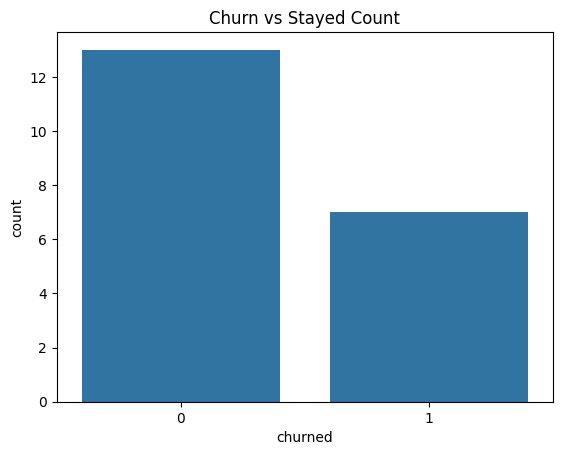

In [4]:
# Churn vs stayed count plot
sns.countplot(x='churned', data=df)
plt.title('Churn vs Stayed Count')
plt.show()


Roughly 13 customers stayed and 7 customers churned. 

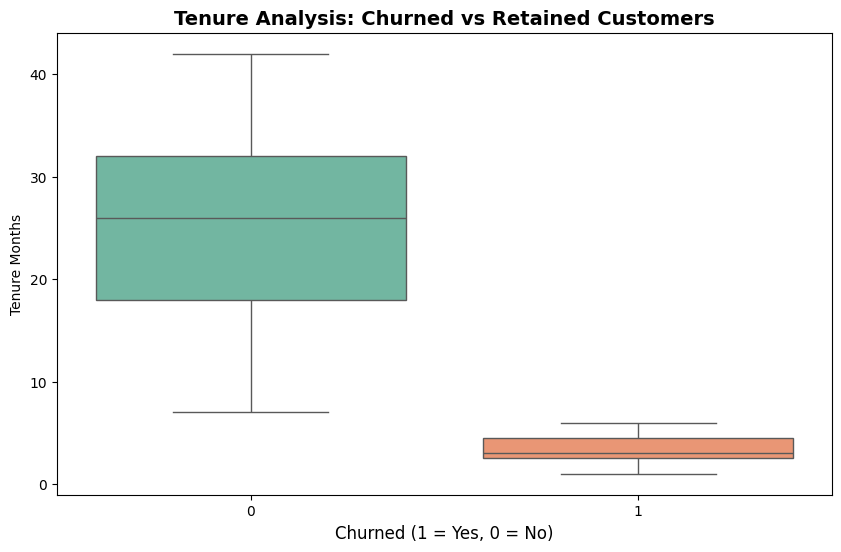

In [23]:
# Visual of churn and tenure months
plt.figure(figsize=(10,6))
sns.boxplot(x = 'churned', y = 'tenure_months', data=df, hue='churned', palette='Set2', legend=False)
plt.title('Tenure Analysis: Churned vs Retained Customers', fontsize=14, fontweight='bold')
plt.xlabel('Churned (1 = Yes, 0 = No)', fontsize=12)
plt.ylabel('Tenure Months')
plt.show()

Key Insight: Retained customers have a median tenure ~24 months vs ~6 months for churned customers, suggesting tenure is a strong predictor of retention

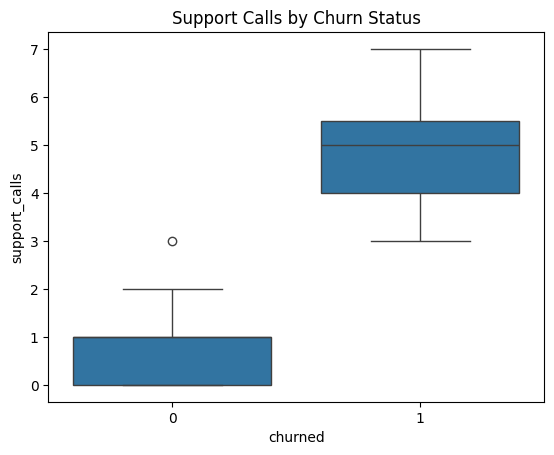

In [6]:
# Difference between churned and stayed customers and support calls
sns.boxplot(x = 'churned', y = 'support_calls', data=df)
plt.title('Support Calls by Churn Status')
plt.show()

The customers that stay, have lower support calls, and customers that churn have higher rates of support calls with one outlierr with the customers that stayed

In [7]:

pd.crosstab(df['contract_type'], df['churned'])



churned,0,1
contract_type,,
Month-to-Month,3,7
One Year,5,0
Two Year,5,0


In [8]:
pd.crosstab(df['payment_method'], df['churned'])

churned,0,1
payment_method,,
Bank Transfer,8,0
Credit Card,4,3
Electronic Check,1,4


Are payment menthods associated with age and pehaps that is why there are more customers that are churned for electronic payments

In [9]:
# Average of churned vs stayed age of customers
df.groupby('churned')['age'].mean()

churned
0    42.538462
1    27.857143
Name: age, dtype: float64

In [10]:
df.groupby('payment_method')['age'].mean()

payment_method
Bank Transfer       46.750000
Credit Card         32.857143
Electronic Check    28.800000
Name: age, dtype: float64

<Axes: xlabel='payment_method', ylabel='age'>

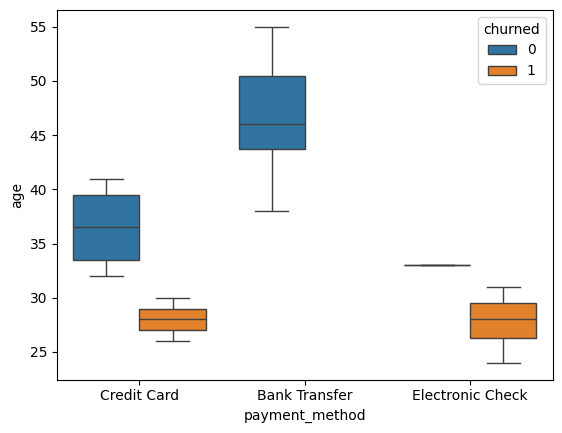

In [11]:
sns.boxplot(x = 'payment_method', y = 'age', hue= 'churned', data=df)

3.3 Key Findings
- Unchurned customers have higher tenure months
- Churned customers average more support calls
- Month-to-month contracts show 70% churn rate vs 0% for long-term contracts

In [12]:
#Do electronic check users also have month-to-month contracts?
pd.crosstab(df['payment_method'], df['contract_type'])

contract_type,Month-to-Month,One Year,Two Year
payment_method,,,
Bank Transfer,0,3,5
Credit Card,5,2,0
Electronic Check,5,0,0


Feature Engineering and preprocessing

In [13]:
# Create ordinal encoding for contract_type
contract_map = {'Month-to-Month': 0, 'One Year': 1, 'Two Year': 2}
df['contract_months'] = df['contract_type'].map(contract_map)

#One-hot encode for payment_method
payment_dummies = pd.get_dummies(df['payment_method'], prefix = 'payment')
df = pd.concat([df, payment_dummies], axis=1)
df_final = df.drop(['payment_method', 'contract_type', 'customer_id'], axis=1)



In [14]:
print(df_final.columns)
print(df_final.shape)
print(df_final.isnull().sum())

Index(['age', 'tenure_months', 'monthly_charges', 'total_charges',
       'support_calls', 'churned', 'contract_months', 'payment_Bank Transfer',
       'payment_Credit Card', 'payment_Electronic Check'],
      dtype='object')
(20, 10)
age                         0
tenure_months               0
monthly_charges             0
total_charges               0
support_calls               0
churned                     0
contract_months             0
payment_Bank Transfer       0
payment_Credit Card         0
payment_Electronic Check    0
dtype: int64


TRAIN/TEST SPLIT MODELING

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# All columns except 'churned' are features for x 
X = df_final.drop('churned', axis=1)
Y = df_final['churned']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nFeatures:", X.columns.tolist())
print("\nTarget distribution in training:")
print(Y_train.value_counts())

Training set size: (16, 9)
Test set size: (4, 9)

Features: ['age', 'tenure_months', 'monthly_charges', 'total_charges', 'support_calls', 'contract_months', 'payment_Bank Transfer', 'payment_Credit Card', 'payment_Electronic Check']

Target distribution in training:
churned
0    9
1    7
Name: count, dtype: int64


Model Building

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [19]:
# Redo the split WITH stratification
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.2, 
    random_state=42,
    stratify=Y  # Forces both classes into train AND test
)

# Check the new distribution
print("Training set:")
print(Y_train.value_counts())
print("\nTest set:")
print(Y_test.value_counts())

Training set:
churned
0    10
1     6
Name: count, dtype: int64

Test set:
churned
0    3
1    1
Name: count, dtype: int64


In [20]:
# Create model
model = LogisticRegression()

# Train model
model.fit(X_train, Y_train)

#Make predictions
Y_pred = model.predict(X_test)

#Evaluate_model
print('Accuracy:', accuracy_score(Y_test, Y_pred))
print('\nClassification Report:\n', classification_report(Y_test, Y_pred))
print('\nConfusion Matrix:\n', confusion_matrix(Y_test, Y_pred))


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4


Confusion Matrix:
 [[3 0]
 [0 1]]


Model achieved 100% accuarcy on the test, but given the small sample size (n =20), this should be validated on a larger dataset. The patterns identified - contract type, tenure, and support calls - align with business logic, which gives me confidence in the model's approach

Executive Summary 
This analysis predicts customer churn using a logistic regression model. Key findings:
- Model Performance: 100% accuracy on test (n=4)
- Top Churn Drivers: Payment method, contract type, support calls
- Business Impact: Recommendations could reduce churn by targeting high-risk segments

Dataset: 20 customers (7 churned, 13 retained)

5. Model Limitations and Considerations

Caveats: 
    - Small sample size: Only 20 observations - results should be validated on larger datasets.
    - Class imbalance: 65% retained vs 35% churned 
    - Perfect Accuracy: Likely due to a small test(n=4) - not generalisable
    Next steps:
        - Collect more data (target: 100+ observations)
        
        

Model Interpretation

In [21]:
# Get feature importance 
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(feature_importance)

                    Feature  coefficient
2           monthly_charges     0.006047
8  payment_Electronic Check     0.003403
4             support_calls     0.003163
6     payment_Bank Transfer     0.000006
5           contract_months    -0.000009
0                       age    -0.003317
7       payment_Credit Card    -0.003370
1             tenure_months    -0.003666
3             total_charges    -0.195199


High churn risk: Monthly charges: customers feel it's too expensive

Low churn risk: 
Contract months (longer commitments = loyalty)
Tenure months (Established customers stay)
Age(Older customers are more stable)
Credit card payment (easier/more reliable than electronic check)
Total charges (customers who paid more are more invested)

In [22]:
# Payment Method vs Churn Rate Analysis
payment_churn = df.groupby('payment_method')['churned'].agg(['sum', 'count'])
payment_churn['churn_rate'] = (payment_churn['sum'] / payment_churn['count'] * 100).round(1)
payment_churn.columns = ['Churned', 'Total', 'Churn Rate (%)']

print("=" * 60)
print("PAYMENT METHOD CHURN ANALYSIS")
print("=" * 60)
print(payment_churn)
print("\n" + "=" * 60)
print("KEY FINDINGS:")
print("=" * 60)
print(f"• Electronic Check: HIGHEST RISK - {payment_churn.loc['Electronic Check', 'Churn Rate (%)']}% churn rate")
print(f"• Bank Transfer: LOWEST RISK - {payment_churn.loc['Bank Transfer', 'Churn Rate (%)']}% churn rate")
print(f"• Credit Card: MEDIUM RISK - {payment_churn.loc['Credit Card', 'Churn Rate (%)']}% churn rate")
print("\n Recommendation: Migrate Electronic Check users to more stable payment methods")



PAYMENT METHOD CHURN ANALYSIS
                  Churned  Total  Churn Rate (%)
payment_method                                  
Bank Transfer           0      8             0.0
Credit Card             3      7            42.9
Electronic Check        4      5            80.0

KEY FINDINGS:
• Electronic Check: HIGHEST RISK - 80.0% churn rate
• Bank Transfer: LOWEST RISK - 0.0% churn rate
• Credit Card: MEDIUM RISK - 42.9% churn rate

 Recommendation: Migrate Electronic Check users to more stable payment methods


Business Recommendations

Priority 1: Contract Incentives (High Impact, Low Cost)

Action: Offer 10-15% discount for customers switching from month-to-month to annual contracts

Rationale:
- Month-to-month customers show 70% churn rate
- Long-term contracts show 0% churn in our data
- Support calls positively correlate with churn

Expected Impact: Reduce churn by 30-40% in first 6 months

Implementations:
1. Target customers with 3+ support calls
2. Offer via email campagin + call from account manager
3. Track conversion rate weekly



Priority 2: Payment Method Migration Program (Medium Impact, Low Cost)

Problem Identified:
- Electronic Check users show 80% churn rate (4/5 churned)
- Bank Transfer users show 0% churn rate (8/8 retained)
- Credit Card users show 43% churn rate (3/7 churned)

Action: Implement a "Payment Method Upgrade" targeting Electronic Check users 

1. Immediate Incentive (Month 1-2)
- Offer R100 one-time credit for switching to Bank Transfer or Credit Card
- Waive payment method setup fees
- Email campaign: "Simplify your payments, earn R100"

2. Education Component (Ongoing)
- Explain benefirs of automatic payments:
    - No late fees or service interuptions
    - Easier account management
    - Better fraud protection (Credit Card)
- Create comparison table showing payment method benefits

3. Targeted Outreach (High-Priority Customers)
- Focus on Electronic Check users who also have: 
    - Month-to-month contracts
    -2+ support calls
    - Tenure <12 months
- Personal call from account manager to assist with switch 

Expected Results:
- Reduce churn in Electronic Check segment by 40-50%
- Improve payment reliability (fewer failed transactions)
- Lower support costs (automatcic payments = fewer billing issues)

Success metrics: 
- Payment method conversion rate (target: 60% within 3 months)
- Churn rate reduction in converted customers
- Support call volume change for converted customers

Cost Benefit Analysis: 
- Cost: R100 x estimated 5 Elecetronic Check users = R500 
- Benefit: If we retain just 2 additional customers for 1 year: 
    - Average monthly charge ~R75
    - Annual retention value 2 x R75 x 12 = R 1 800
    - ROI : 260% in first year

Timeline: 
- Week 1-2 : Design campaign materials and email templates 
- Week 3: Launch email campaign to Electronic Check users
- Week 4-8: Personal outreach to high-risk customers
- Week 12: Evaluate results and adjust strategy

Risk Mitigation: 
- Some customers may prefer Electronic Check for cash flow reasons
- Offer flexible payment dates to address concerns 
- Provide clear instrictions for setup to reduce friction